In [1]:
import netgen.gui
from ngsolve import *
import numpy as np
import scipy.sparse as sp

from math import pi
from numpy import linalg as LA
import matplotlib.pyplot as plt

### Erstellt ein Quadrat mit der Länge $1$ 
### und setzt einen Impuls in der Mitte des Quadrats

In [2]:
import netgen.geom2d as geom2dim
geo = geom2dim.SplineGeometry()
a = 1
points = [(0,0),(a,0),(a,a),(0,a)]
p1,p2,p3,p4 = [geo.AppendPoint(*pnt) for pnt in points]
curves = [['line',p1,p2],['line',p2,p3],['line',p3,p4],['line',p4,p1]]
[geo.Append(c) for c in curves]

mesh = Mesh(geo.GenerateMesh(maxh = 0.1))


piha = a/2
shift = 0
source = exp(-50**2*((x-piha-shift)*(x-piha-shift)+(y-piha-shift)*(y-piha-shift)))
Draw(source,mesh,name = "pulse")

In [19]:
maxind = 20
#fes = H1(mesh, order=5)
fes = H1(mesh, order=5,dirichlet=".*")
gfu = GridFunction(fes,name = "u")
erg = np.zeros([len(gfu.vec),maxind])
fh = np.zeros(len(gfu.vec))

### The gereral solution form the helmholz equation is 
$u = \sin(l \pi x)\sin(k \pi y)$

when we plug now this ansatz in the helmholz equation:

$k^2\pi^2u+l^2\pi^2u -\omega^2u = 0$

For $u \neq 0$ it follows that:

$k^2\pi^2+l^2\pi^2 = \omega^2$ $\Rightarrow$ $\omega = \sqrt{k^2\pi^2+l^2\pi^2}$ where $k,l \in \mathbb{N}$

In [20]:
verg = []
point = []
j = 0
temp = 0
for k in range(1,20):
    for l in range(1,20):
        temp = np.sqrt(l**2*pi**2+k**2*pi**2)
        if l > 1:
            if temp == verg[j-1]:
                temp = 0
        else:
            verg.append(temp)
    j = j+1
            
        
verg.sort()       
print(verg)

[4.442882938158366, 7.024814731040727, 9.934588265796101, 12.953118343415191, 16.01904224441409, 19.10956207871615, 22.21441469079183, 25.32832971340211, 28.448331425398703, 31.57261542080455, 34.700025027842585, 37.829785066240554, 40.9613567668991, 44.09435413989645, 47.22849346153437, 50.36356154085973, 53.49939510233657, 56.63586699569489, 59.7728767351409]


### Die helmholzgleichung:
$\Delta u - \omega^2 u = f$
### und die Schwache Formulierung:
$\int_{\Omega}\nabla u \nabla v - \omega^2\int_{\Omega}u v = \int_{\Omega}fv$ $v \in V$
### löse die obrige Gleichung mit paar $\omega_i$ und speichere diese $u_i$ in eine Matrix 

In [21]:
u = fes.TrialFunction()
v = fes.TestFunction()

A = BilinearForm(fes)
K = BilinearForm(fes)
M = BilinearForm(fes)
F = LinearForm(fes)

omega = Parameter(1)
A += (grad(u)*grad(v)- omega**2*u*v)*dx
K += grad(u)*grad(v)*dx
M += u*v*dx


#A += 1j*omega*u*v*ds # R 
F += source*v*dx  
o = []  

norm = []

#o = verg[0:21]
for i in range(0,maxind):
    o.append(i)

j = 0
Draw(gfu)
for i in o:   
    omega.Set(i) 
    A.Assemble()
    K.Assemble()
    M.Assemble()
    F.Assemble()   
    gfu.vec.data = A.mat.Inverse(fes.FreeDofs()) * F.vec
    erg[:,j] = gfu.vec
    fh = F.vec
    norm.append(sqrt (Integrate ((gfu)*(gfu),mesh)))
    print("Number of iter: ",j,"omega: ",i,"L2-Norm:",sqrt (Integrate ((gfu)*(gfu),mesh)))
    j = j+1
As = A.mat
Ms = M.mat
Ks = K.mat
rows,cols,vals = Ms.COO()
Mh = sp.csr_matrix((vals,(rows,cols)))
rows,cols,vals = Ks.COO()
Kh = sp.csr_matrix((vals,(rows,cols)))
rows,cols,vals = As.COO()
Ah = sp.csr_matrix((vals,(rows,cols)))
Ah = sp.csr_matrix.toarray(Ah)

Number of iter:  0 omega:  0 L2-Norm: 0.00013380101003921885
Number of iter:  1 omega:  1 L2-Norm: 0.0001402878457279806
Number of iter:  2 omega:  2 L2-Norm: 0.00016482056456664925
Number of iter:  3 omega:  3 L2-Norm: 0.00023693872648335623
Number of iter:  4 omega:  4 L2-Norm: 0.0006685491574203242
Number of iter:  5 omega:  5 L2-Norm: 0.0004770687190558173
Number of iter:  6 omega:  6 L2-Norm: 0.00016593496254364062
Number of iter:  7 omega:  7 L2-Norm: 0.00011927190707528837
Number of iter:  8 omega:  8 L2-Norm: 0.00012061279428570506
Number of iter:  9 omega:  9 L2-Norm: 0.00020543447727135902
Number of iter:  10 omega:  10 L2-Norm: 0.002682337857814545
Number of iter:  11 omega:  11 L2-Norm: 0.00016821069962874135
Number of iter:  12 omega:  12 L2-Norm: 0.00011528049938742794
Number of iter:  13 omega:  13 L2-Norm: 0.0002929258237513671
Number of iter:  14 omega:  14 L2-Norm: 0.000153767658568584
Number of iter:  15 omega:  15 L2-Norm: 0.00013011752800525707
Number of iter:  16 

### calulates the orthogonal basis matrix V (using qr)

In [22]:
V, r = np.linalg.qr(erg)
V = erg.dot(np.linalg.inv(r))
print(V[:,1].dot(V[:,2]))
len(V)
#lam,v = LA.eig(Ah)
#q,R = np.linalg.qr(Ah)
#print(np.diag(R))

-3.812922200197022e-14


2976

### Eigenvalue calculation with eig and qr (very expensive)

In [ ]:
q,R = np.linalg.qr(Ah)

In [ ]:
#print("from eig: ",lam[0:20])
eig = []
eig = np.diag(R)*np.diag(R)
for i in verg:
    for j in range(len(eig)):
        #print(np.abs(i-eig[j]))
        if np.abs(i-eig[j]) < 0.1:
            print(j,eig[j])
#print("from qr: ",eig[0:1000])

### Plot the snapshot solution 

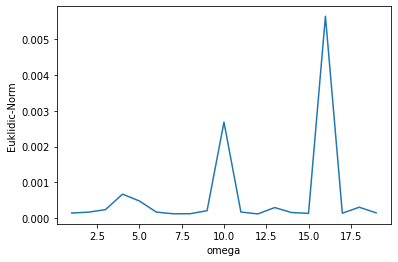

In [23]:
plt.plot(o[1:20],norm[1:20])
plt.xlabel("omega")
plt.ylabel("Euklidic-Norm")
plt.savefig('results/resonanz_20.png')

### Für die erste Metode GramSchmid verwenden um eine orthonormale Koordinatentransformationsmatrix zu erstellen(Euklidische Norm). 

$$
M_N = V^T \cdot M_h \cdot V
$$

$$
K_N = V^T \cdot K_h \cdot V
$$

$$
f_N = V^T \cdot f_h
$$

$$
u_i = (K_N - \omega^2_iM_N)^{-1} \cdot f_N
$$

In [24]:
MN = np.transpose(V).dot(Mh.dot(V))
KN = np.transpose(V).dot(Kh.dot(V))
fN = np.transpose(V).dot(fh)

### calculate the res, red_solution and res_red snapshot solution 

In [25]:
j = 0
uN = np.zeros([maxind,maxind])
res_red_fh = []
res_red_fN = []
for fre in o:
    uN[:,j] = np.linalg.solve(KN-fre**2*MN, fN)
    res_red_fh.append(np.linalg.norm((Kh-fre**2*Mh).dot(uN[:,j].dot(np.transpose(V)))-fh))
    res_red_fN.append(np.linalg.norm((Kh-fre**2*Mh).dot(uN[:,j].dot(np.transpose(V)))-fN.dot(np.transpose(V))))
    j = j+1

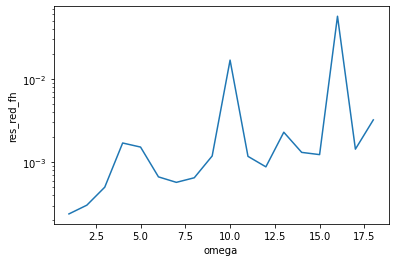

In [26]:
plt.semilogy(o[1:19],res_red_fh[1:19])
plt.xlabel("omega")
plt.ylabel("res_red_fh")
plt.savefig('results/resonanz_RB_20.png')

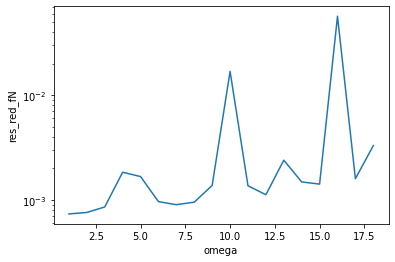

In [27]:
plt.semilogy(o[1:19],res_red_fN[1:19])
plt.xlabel("omega")
plt.ylabel("res_red_fN")
plt.savefig('results/resonanz_RB_20.png')

In [30]:
iteration = int(100)
interval = 20
factor = interval / iteration
omegaN = []
norm_L2 =[]
uN = np.zeros([maxind,iteration])
for i in range(iteration):
    omegaN.append(factor*i)
    uN[:,i] = np.linalg.solve(KN-omegaN[i]**2*MN, fN)
    new = uN[:,i].dot(np.transpose(V))
    gif = GridFunction(fes,name = "gif")
    gif.vec.FV().NumPy()[:] = new
    Draw(gif)
    print("i: ",i,"Omega: ",omegaN[i])
    input()
    Redraw()
    #norm_L2.append(sqrt(uN[:,i].dot(uN[:,i])))

i:  0 Omega:  0.0

i:  1 Omega:  0.2

i:  2 Omega:  0.4

i:  3 Omega:  0.6000000000000001

i:  4 Omega:  0.8

i:  5 Omega:  1.0

i:  6 Omega:  1.2000000000000002

i:  7 Omega:  1.4000000000000001

i:  8 Omega:  1.6

i:  9 Omega:  1.8

i:  10 Omega:  2.0

i:  11 Omega:  2.2

i:  12 Omega:  2.4000000000000004

i:  13 Omega:  2.6

i:  14 Omega:  2.8000000000000003

i:  15 Omega:  3.0

i:  16 Omega:  3.2

i:  17 Omega:  3.4000000000000004

i:  18 Omega:  3.6

i:  19 Omega:  3.8000000000000003

i:  20 Omega:  4.0

i:  21 Omega:  4.2

i:  22 Omega:  4.4

i:  23 Omega:  4.6000000000000005

i:  24 Omega:  4.800000000000001

i:  25 Omega:  5.0

i:  26 Omega:  5.2

i:  27 Omega:  5.4

i:  28 Omega:  5.6000000000000005

i:  29 Omega:  5.800000000000001

i:  30 Omega:  6.0

i:  31 Omega:  6.2

i:  32 Omega:  6.4

i:  33 Omega:  6.6000000000000005

i:  34 Omega:  6.800000000000001

i:  35 Omega:  7.0

i:  36 Omega:  7.2

i:  37 Omega:  7.4

i:  38 Omega:  7.6000000000000005

i:  39 Omega:  7.800000

### calculates 1000 residuals and the norm of the rediced solution (very expensive)

In [33]:
verg = []
point = []
for k in range(1,100):
    for l in range(1,100):
        verg.append(np.sqrt(l**2*pi**2+k**2*pi**2))
        point.append(0.1)


iteration = int(1e4)
interval = 20
factor = interval / iteration
omegaN = []
norm_L2 =[]
res = []
uN = np.zeros([maxind,iteration])
for i in range(iteration):
    omegaN.append(factor*i)
    uN[:,i] = np.linalg.solve(KN-omegaN[i]**2*MN, fN)
    res.append(np.linalg.norm((Kh-omegaN[i]**2*Mh).dot(uN[:,i].dot(np.transpose(V)))-fN.dot(np.transpose(V))))
    norm_L2.append(sqrt(uN[:,i].dot(uN[:,i])))
    
    

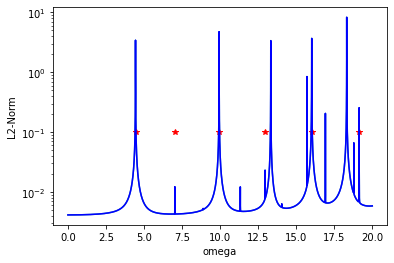

In [35]:
maxpoints = 6
plt.semilogy(omegaN,norm_L2)
plt.semilogy(verg[0:maxpoints],point[0:maxpoints],'*r')
plt.semilogy(omegaN,norm_L2,'b')
plt.xlabel("omega")
plt.ylabel("Euclidic Norm")
plt.savefig('results/resonanz_RB_20.png')

In [36]:
print(verg[0:7])

[4.442882938158366, 7.024814731040727, 9.934588265796101, 12.953118343415191, 16.01904224441409, 19.10956207871615, 22.21441469079183]


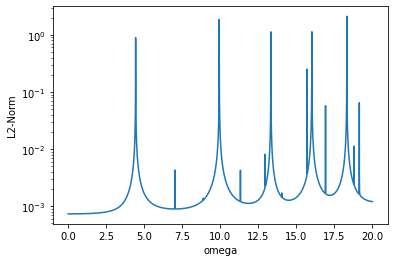

In [37]:
plt.semilogy(omegaN,res)
plt.xlabel("omega")
plt.ylabel("Euclidic Norm")
plt.savefig('results/resonanz_RB_20.png')

In [18]:
newom = []
for i in range(len(res)):
    if res[i] < 6.94e-4:
        print(i,omegaN[i],res[i])
        newom.append(omegaN[i])
    

628 12.56 0.0006931663375530333
786 15.72 0.000691917825573587
844 16.88 0.0006937171707730886
845 16.9 0.0006923934402360873
874 17.48 0.0006939923578125265
875 17.5 0.0006939346334240137
876 17.52 0.0006938706088510701
877 17.54 0.0006937988707688901
878 17.56 0.0006937175491126919
879 17.580000000000002 0.0006936241167944797
880 17.6 0.0006935150798983524
881 17.62 0.0006933854889613287
882 17.64 0.0006932281622210512
883 17.66 0.0006930324930336596
884 17.68 0.0006927829891206738
885 17.7 0.0006924602689253953
886 17.72 0.0006920697359039961
887 17.740000000000002 0.0006920050394301464
912 18.240000000000002 0.0006939415932500139
913 18.26 0.0006938740802736398
914 18.28 0.0006938061614839294
915 18.3 0.0006937375684370167
916 18.32 0.0006936680505105247
917 18.34 0.0006935973695207908
918 18.36 0.0006935252952702168
919 18.38 0.0006934516018312202
920 18.400000000000002 0.0006933760644618811
921 18.42 0.000693298457139993
922 18.44 0.0006932185508153688
923 18.46 0.000693136112642